In [566]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso

import pysindy as ps
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [567]:
from stesml.data_tools import get_scenario_index
from stesml.data_tools import get_train_and_val_index

In [568]:
def load_data(scenario_index, selected_index, t_min=-1, t_max=-1):
    """ Load data from files in scenario_index with indices matching ones in selected_index"""
    df_arr = []
    for f in scenario_index.loc[selected_index].filepath:
        Tw = float(f.split("/")[-1].split("_")[1])
        Ti = float(f.split("/")[-1].split("_")[2].replace(".csv", ""))
        f_df = pd.read_csv(f, skiprows=[i for i in range(1,65)])
        f_df["Ti"] = Ti
        if t_min > 0:
            f_df = f_df[f_df['flow-time'] >= t_min]
        if t_max > 0:
            f_df = f_df[f_df['flow-time'] <= t_max]
        df_arr.append(f_df)
    combined_df = pd.concat(df_arr)
    return combined_df

In [569]:
data_dir = "../data/Sulfur_Models/heating/heating_all"

In [570]:
scenario_index = get_scenario_index(data_dir)

In [571]:
train_index, val_index = get_train_and_val_index(scenario_index, random_state=5)

In [572]:
train_data = load_data(scenario_index, train_index)

In [573]:
train_df = train_data[['Tw','Ti','Tavg']]

In [574]:
train_df.index = train_data['flow-time']

In [575]:
train_df

,Tw,Ti,Tavg
flow-time,,,
2.110680,540,400.0,401.297945
2.210680,540,400.0,401.330161
2.310680,540,400.0,401.361742
2.410680,540,400.0,401.391744
2.510680,540,400.0,401.421288
...,...,...,...
7199.604681,460,400.0,429.384154
7199.704681,460,400.0,429.384296
7199.804681,460,400.0,429.384439


In [576]:
val_data = load_data(scenario_index, val_index)

In [577]:
val_df = val_data[['Tw','Ti','Tavg']]

In [578]:
val_df.index = val_data['flow-time']

In [579]:
val_df

,Tw,Ti,Tavg
flow-time,,,
4.566673,560,440.0,441.672354
4.666673,560,440.0,441.690716
4.766673,560,440.0,441.708864
4.866673,560,440.0,441.726804
4.966673,560,440.0,441.744545
...,...,...,...
359.669535,520,440.0,446.627400
359.769535,520,440.0,446.627971
359.869535,520,440.0,446.628541


In [580]:
train_data_list = list()
index_list = list()
for idx, grp in train_df.groupby(["Tw", "Ti"]):
    train_data_list.append(grp.values)
    index_list.append(grp.index.values)

In [581]:
val_data_list = list()
val_index_list = list()
for idx, grp in val_df.groupby(["Tw", "Ti"]):
    val_data_list.append(grp.values)
    val_index_list.append(grp.index.values)

In [673]:
poly_library = ps.PolynomialLibrary(degree=2, include_interaction=True)
fourier_library = ps.FourierLibrary()
combined_library = poly_library + fourier_library

In [674]:
sparse_regression_optimizer = ps.STLSQ(threshold=0,normalize_columns=True,verbose=True)
model = ps.SINDy(sparse_regression_optimizer, feature_library=poly_library)

In [675]:
model.fit(train_data_list, t=index_list, multiple_trajectories=True)
model.print()

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 3.8799e+02 ... 1.9856e+01 ...         30 ... 4.0785e+02
(x0)' = 0.000
(x1)' = 0.000
(x2)' = 0.074 1


In [676]:
res_list = list()
for i in range(len(val_data_list)):
    res = model.simulate(x0=np.array(val_data_list[i][0]).reshape(3),t=val_index_list[i])
    res_list.append(res)

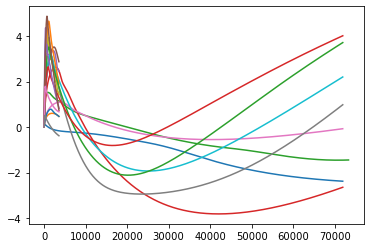

In [677]:
for i in range(len(val_data_list)):
    plt.plot(val_data_list[i][:,2] - res_list[i][:,2])

In [678]:
vdl = list()
rl = list()
for i, vd in enumerate(val_data_list):
    for point in vd[:,2]:
        vdl.append(point)
for i, r in enumerate(res_list):
    for point in r[:,2]:
        rl.append(point)

In [679]:
r2 = r2_score(vdl, rl)
rmse = mean_squared_error(vdl, rl, squared=False)
print(f'RMSE: {rmse}, R2: {r2}')

RMSE: 1.8317628003381217, R2: 0.9985857005561332


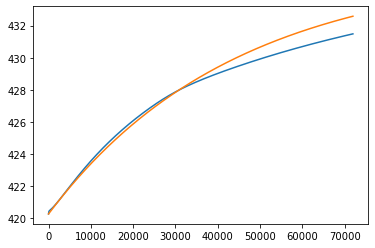

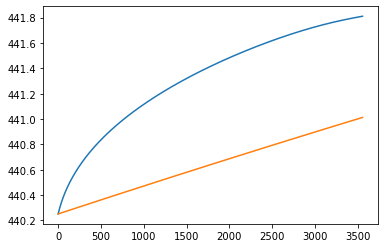

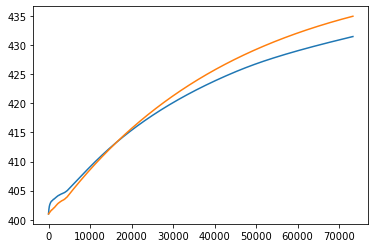

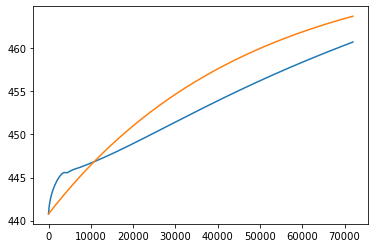

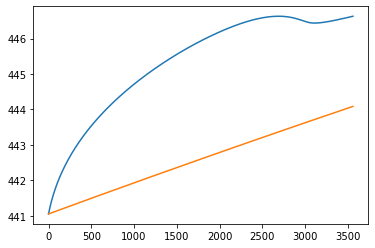

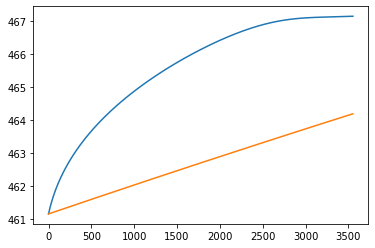

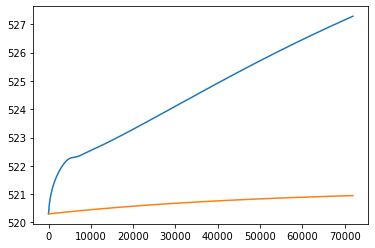

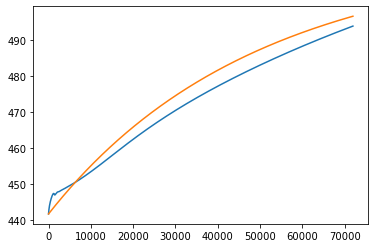

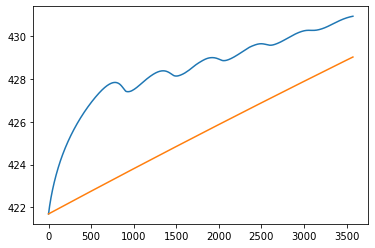

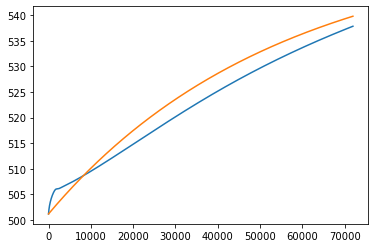

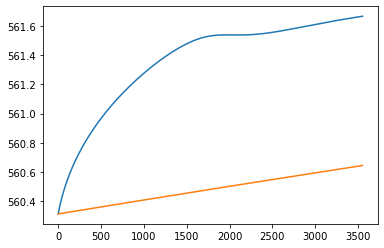

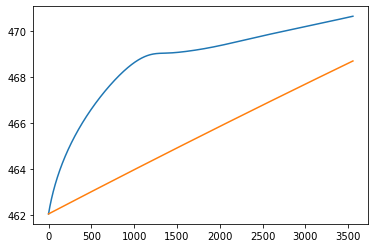

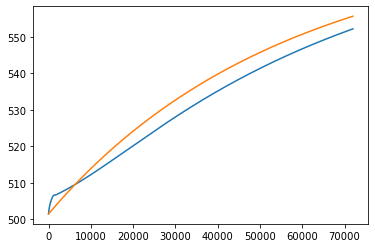

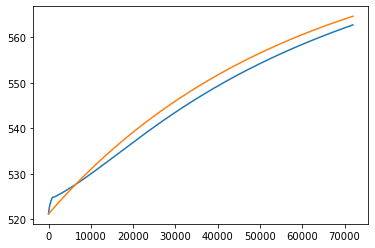

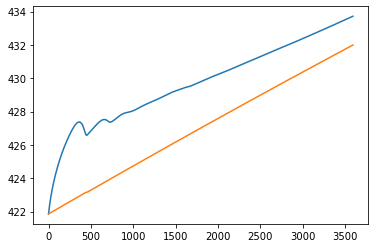

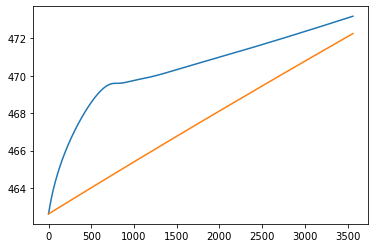

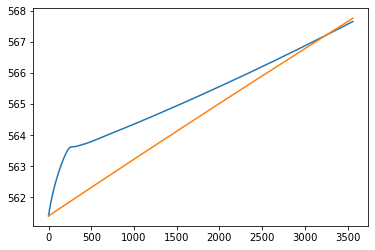

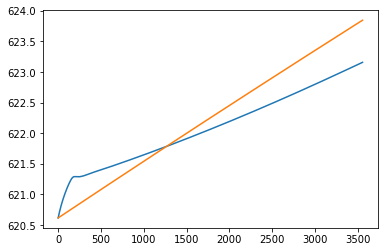

In [672]:
for i in range(len(val_data_list)):
    plt.plot(val_data_list[i][:,2])
    plt.plot(res_list[i][:,2])
    plt.show()